In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import scvi
import torch


/opt/homebrew/Caskroom/miniforge/base/envs/rl_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
raw_data_path = './raw/HumanBrainAtlas_processed.h5ad'


In [3]:
# Load the h5ad file
adata = sc.read_h5ad(raw_data_path)
print(f"Loaded data with shape: {adata.shape}")
print(f"Number of cells: {adata.n_obs}")
print(f"Number of genes: {adata.n_vars}")
print(f"Available metadata: {list(adata.obs.columns)}")


Loaded data with shape: (354361, 32165)
Number of cells: 354361
Number of genes: 32165
Available metadata: ['Class', 'Region', 'sex', 'development_stage', 'Batch_ID', 'Age', '_scvi_batch', '_scvi_labels', 'doublet', 'singlet', 'leiden']


## Data Check

In [4]:
adata

AnnData object with n_obs × n_vars = 354361 × 32165
    obs: 'Class', 'Region', 'sex', 'development_stage', 'Batch_ID', 'Age', '_scvi_batch', '_scvi_labels', 'doublet', 'singlet', 'leiden'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'leiden', 'leiden_colors', 'leiden_sizes', 'neighbors', 'paga', 'umap'
    obsm: 'X_umap', 'scVI'
    obsp: 'connectivities', 'distances'

In [5]:
for cell_tpye in adata.obs['Class'].unique():
    print(cell_tpye)

Oligodendrocyte
Committed oligodendrocyte precursor
Astrocyte
Oligodendrocyte precursor
Ependymal
Choroid plexus
Fibroblast
Vascular
Microglia
CGE interneuron
MGE interneuron
Splatter
Midbrain-derived inhibitory
Medium spiny neuron


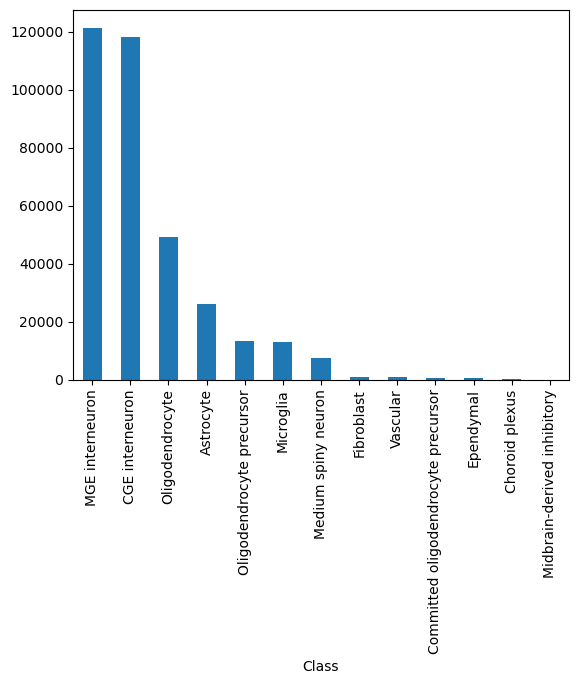

In [6]:
adata = adata[adata.obs['Class'] != 'Splatter']
adata.obs['Class'].unique()
adata.obs['Class'].value_counts()
adata.obs['Class'].value_counts().plot(kind='bar')
plt.show()


Drop for now (to reduce complexity)

- CGE interneuron, Microglia, Medium spiny neuron, Ependymal, Choroid plexus, Midbrain-derived inhibitory.

Why this subset?

- Maximizes PNN-centric signal (MGE) + ECM source/modulator classes (OPC/OL/Astro).
- Keeps enough cells per class for stable RL rewards while avoiding low-abundance distractions.

In [7]:
adata = adata[adata.obs['Class'] != 'CGE interneuron']
adata = adata[adata.obs['Class'] != 'Microglia']
adata = adata[adata.obs['Class'] != 'Medium spiny neuron']
adata = adata[adata.obs['Class'] != 'Ependymal']
adata = adata[adata.obs['Class'] != 'Choroid plexus']
adata = adata[adata.obs['Class'] != 'Midbrain-derived inhibitory']


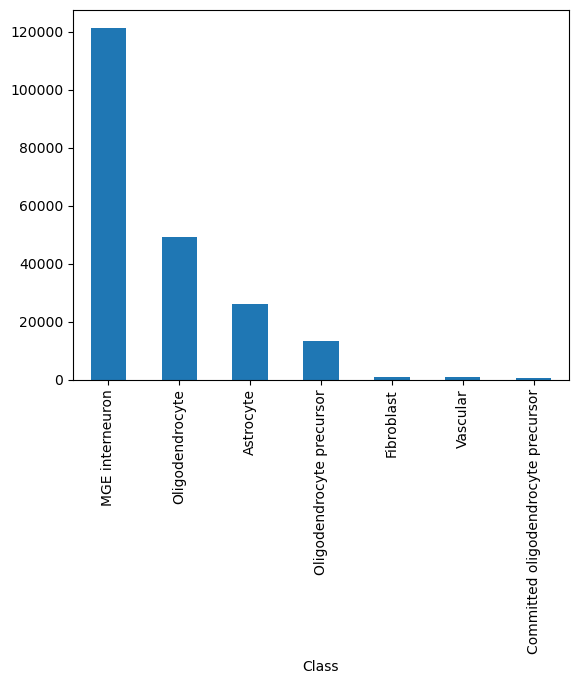

In [8]:
adata.obs['Class'].value_counts().plot(kind='bar')
plt.show()


The data already has scVI vectors, but they are small (14 dims). Lets make them again, but much larger

In [9]:
adata.obsm['scVI'][0].shape

(14,)

In [10]:
adata

View of AnnData object with n_obs × n_vars = 212245 × 32165
    obs: 'Class', 'Region', 'sex', 'development_stage', 'Batch_ID', 'Age', '_scvi_batch', '_scvi_labels', 'doublet', 'singlet', 'leiden'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'leiden', 'leiden_colors', 'leiden_sizes', 'neighbors', 'paga', 'umap'
    obsm: 'X_umap', 'scVI'
    obsp: 'connectivities', 'distances'

## Train the scVI to get embeddings

In [11]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.3.3


In [13]:
adata = adata.copy()

In [14]:
# Set up scVI model
# First, we need to prepare the data for scVI
scvi.model.SCVI.setup_anndata(adata, layer=None, batch_key='Batch_ID')

# Create the scVI model
model = scvi.model.SCVI(adata, n_latent=40)  # 10-dimensional latent space


In [ ]:
# Train the scVI model
print("Training scVI model...")
model.train(max_epochs=400, train_size=0.9, early_stopping=True, accelerator='mps')

# Check training history
print("Training completed!")
# print(f"Final training loss: {model.history['train_loss_epoch'][-1]:.4f}")
# print(f"Final validation loss: {model.history['validation_loss'][-1]:.4f}")


/opt/homebrew/Caskroom/miniforge/base/envs/rl_env/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been set to `mps`. Please note that not all PyTorch/Jax operations are supported with this backend. as a result, some models might be slower and less accurate than usuall. Please verify your analysis!Refer to https://github.com/pytorch/pytorch/issues/77764 for more details.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training scVI model...


/opt/homebrew/Caskroom/miniforge/base/envs/rl_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/opt/homebrew/Caskroom/miniforge/base/envs/rl_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|██████████| 400/400 [5:43:16<00:00, 44.99s/it, v_num=1, train_loss_step=1.01e+4, train_loss_epoch=8.79e+3]  

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [5:43:16<00:00, 51.49s/it, v_num=1, train_loss_step=1.01e+4, train_loss_epoch=8.79e+3]
Training completed!


KeyError: -1

In [16]:
# Extract representation vectors (latent embeddings)
print("Extracting representation vectors...")
latent_representations = model.get_latent_representation()

# Add the representations to the AnnData object


adata.obsm['X_scvi_large'] = latent_representations

print(f"Representation vectors shape: {latent_representations.shape}")
print(f"Each cell is represented by a {latent_representations.shape[1]}-dimensional vector")

# Display first few representation vectors
print("\nFirst 5 representation vectors:")
print(latent_representations[:5])


Extracting representation vectors...
Representation vectors shape: (212245, 40)
Each cell is represented by a 40-dimensional vector

First 5 representation vectors:
[[-6.70295537e-01 -2.32671022e-01 -1.33127511e+00 -7.92338476e-02
   6.75721705e-01  9.87897336e-01 -1.39661312e+00 -1.56720448e+00
  -4.22852248e-01  8.24840833e-03  1.03603363e+00 -9.77629006e-01
  -3.11167240e-01  6.69411898e-01 -2.45897368e-01 -4.26819980e-01
  -8.40656161e-01 -2.88186741e+00  2.70280600e-01 -4.12117481e-01
   4.78570580e-01  1.25608757e-01  3.72775257e-01  5.70760965e-01
  -3.86470616e-01 -5.81550360e-01  8.62926245e-01  6.50474370e-01
  -2.00275362e-01  6.04297280e-01 -8.87374997e-01  2.65922427e-01
  -8.45555007e-01  4.78086174e-01 -2.14719623e-02 -2.21598312e-01
   3.73225939e-03 -5.73673248e-01  4.47610319e-01  1.67124033e-01]
 [-4.97090995e-01 -9.84372020e-01 -1.49230528e+00 -5.61721623e-04
   6.06956422e-01  7.87310958e-01 -1.25537372e+00  4.64481473e-01
  -1.72067225e-01  1.22605907e-02  1.58841

Creating UMAP visualization of scVI representations...


AttributeError: 'numpy.ndarray' object has no attribute '_sanitize'

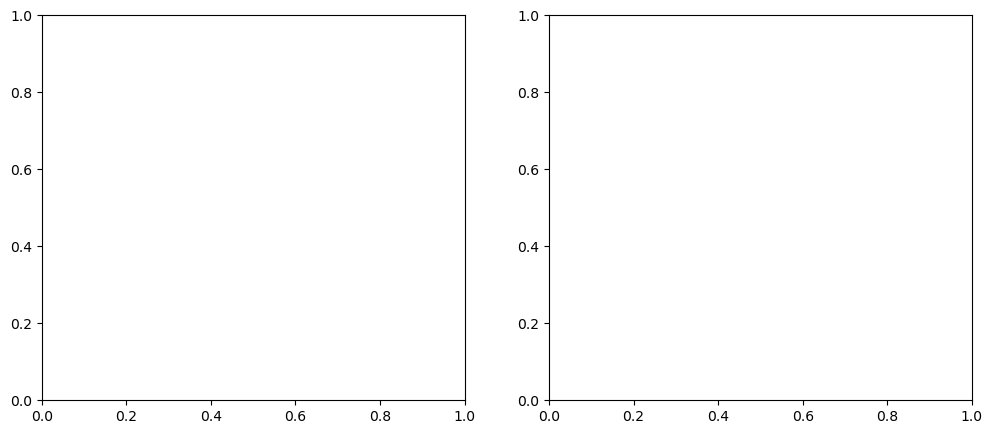

In [23]:
# Visualize the representation vectors using UMAP
print("Creating UMAP visualization of scVI representations...")

# Use scVI representations for UMAP
# adata.obsm['X_umap_large'] = sc.tl.umap(adata, use_rep='X_scvi_large', copy=True).obsm['X_umap']

# Plot UMAP colored by scVI representations
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# UMAP plot
sc.pl.umap(adata.obsm['X_scvi_large'], color='cell_tpye', ax=axes[0], show=False)
axes[0].set_title('UMAP of scVI Representations')

# Distribution of representation values
axes[1].hist(latent_representations.flatten(), bins=50, alpha=0.7)
axes[1].set_title('Distribution of scVI Representation Values')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Save the data with scVI representations



In [20]:
adata.obsm['X_scvi_large'][0].shape

(40,)

In [ ]:
#output_path = 'data/interim/data_with_scvi_representations.h5ad'
#adata.write('human_brain_atlas_processed_scvi_large.h5ad')
print(f"Data with scVI representations saved to: {output_path}")

Data with scVI representations saved to: data/interim/data_with_scvi_representations.h5ad


In [24]:
# Comprehensive visualization of X_scvi_large embeddings
print("Creating comprehensive visualizations of X_scvi_large embeddings...")

# 1. First, compute UMAP using the scVI embeddings
print("Computing UMAP...")
sc.pp.neighbors(adata, use_rep='X_scvi_large', n_neighbors=15, n_pcs=40)
sc.tl.umap(adata)

# 2. Create a comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# UMAP colored by cell type
sc.pl.umap(adata, color='Class', ax=axes[0,0], show=False, legend_loc='right margin')
axes[0,0].set_title('UMAP colored by Cell Type')

# UMAP colored by region
sc.pl.umap(adata, color='Region', ax=axes[0,1], show=False, legend_loc='right margin')
axes[0,1].set_title('UMAP colored by Brain Region')

# UMAP colored by development stage
sc.pl.umap(adata, color='development_stage', ax=axes[0,2], show=False, legend_loc='right margin')
axes[0,2].set_title('UMAP colored by Development Stage')

# Distribution of embedding values
axes[1,0].hist(adata.obsm['X_scvi_large'].flatten(), bins=50, alpha=0.7, color='skyblue')
axes[1,0].set_title('Distribution of scVI Embedding Values')
axes[1,0].set_xlabel('Embedding Value')
axes[1,0].set_ylabel('Frequency')

# Heatmap of first 20 dimensions for first 1000 cells
embedding_subset = adata.obsm['X_scvi_large'][:1000, :20]
im = axes[1,1].imshow(embedding_subset.T, aspect='auto', cmap='RdBu_r')
axes[1,1].set_title('Heatmap: First 20 Dimensions (1000 cells)')
axes[1,1].set_xlabel('Cells')
axes[1,1].set_ylabel('Embedding Dimensions')
plt.colorbar(im, ax=axes[1,1])

# Variance explained by each dimension
dim_variances = np.var(adata.obsm['X_scvi_large'], axis=0)
axes[1,2].bar(range(len(dim_variances)), dim_variances, alpha=0.7, color='lightcoral')
axes[1,2].set_title('Variance by Embedding Dimension')
axes[1,2].set_xlabel('Dimension')
axes[1,2].set_ylabel('Variance')

plt.tight_layout()
plt.show()

print(f"Embedding shape: {adata.obsm['X_scvi_large'].shape}")
print(f"Mean embedding value: {np.mean(adata.obsm['X_scvi_large']):.4f}")
print(f"Std embedding value: {np.std(adata.obsm['X_scvi_large']):.4f}")


Creating comprehensive visualizations of X_scvi_large embeddings...
Computing UMAP...


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


: 

In [ ]:
# Additional visualization methods for X_scvi_large embeddings
print("Creating additional visualizations...")

# 1. PCA visualization
print("Computing PCA...")
sc.tl.pca(adata, use_rep='X_scvi_large', n_comps=50)

# 2. t-SNE visualization
print("Computing t-SNE...")
sc.tl.tsne(adata, use_rep='X_scvi_large', n_pcs=40)

# Create additional plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# PCA plot colored by cell type
sc.pl.pca(adata, color='Class', ax=axes[0,0], show=False, legend_loc='right margin')
axes[0,0].set_title('PCA colored by Cell Type')

# t-SNE plot colored by cell type
sc.pl.tsne(adata, color='Class', ax=axes[0,1], show=False, legend_loc='right margin')
axes[0,1].set_title('t-SNE colored by Cell Type')

# UMAP colored by batch
sc.pl.umap(adata, color='Batch_ID', ax=axes[1,0], show=False, legend_loc='right margin')
axes[1,0].set_title('UMAP colored by Batch')

# UMAP colored by age
sc.pl.umap(adata, color='Age', ax=axes[1,1], show=False, legend_loc='right margin')
axes[1,1].set_title('UMAP colored by Age')

plt.tight_layout()
plt.show()

# Print some statistics about the embeddings
print("\n=== Embedding Statistics ===")
print(f"Shape: {adata.obsm['X_scvi_large'].shape}")
print(f"Min value: {np.min(adata.obsm['X_scvi_large']):.4f}")
print(f"Max value: {np.max(adata.obsm['X_scvi_large']):.4f}")
print(f"Mean: {np.mean(adata.obsm['X_scvi_large']):.4f}")
print(f"Std: {np.std(adata.obsm['X_scvi_large']):.4f}")

# Check for any NaN values
nan_count = np.isnan(adata.obsm['X_scvi_large']).sum()
print(f"NaN values: {nan_count}")

# Check correlation between first few dimensions
corr_matrix = np.corrcoef(adata.obsm['X_scvi_large'][:1000, :10].T)
print(f"\nCorrelation matrix shape (first 10 dims): {corr_matrix.shape}")
